<a class="anchor" id="top"></a>
**Formation Data Scientist - Projet 4**

**Anticipez les besoins en consommation électrique de bâtiments**

**Partie 2 - Modélisations - estimation de SiteEnergyUse(kBtu)**

Antoine LEPAGE <br /> 
yop1001@gmail.com

https://openclassrooms.com/fr/projects/629/assignment

**Table des matières**

1. [Modélisations - estimation de *SiteEnergyUse(kBtu)*](#modelisations_SiteEnergyUse(kBtu))<br />
      
    1.1. [Preprocessing](#preprocessing)<br />
    1.1.1 [Choix des variables](#choix_variables_2)<br />
    1.1.2.[Encodage de la variable qualitative](#encodage)<br />
    1.1.3.[Séparation train et test sets ](#train_test)<br />
    1.1.4.[Standardisation](#var_standardisation)<br />
    
    1.2. [Régressions linéaires](#regressions_lineaires)<br />
    
    1.2.1. [Régression linéaire standard](#regression_lineaire)<br />
    1.2.1.1. [régression linéaire (sans CV)](#linreg_classique)<br />
    1.2.1.2. [régression linéaire (avec CV)](#linreg_CV)<br />
    
    1.2.2. [Régression Ridge](#regression_ridge)<br />
    1.2.2.1. [Recherche du meilleur alpha](#ridge_alpha)<br />
    1.2.2.2. [Regression Ridge (avec CV)](#ridge_CV)<br />   
    
    1.2.3. [Régression Lasso](#regression_lasso)<br />
    1.2.3.1. [Recherche du meilleur alpha](#lasso_alpha)<br />
    1.2.3.2. [Regression Lasso (avec CV)](#lasso_CV)<br />  
        
    1.3. [Régressions non linéaires](#regressions_non_lineaires)<br />
    1.3.1. [Support Vector Regression (SVR)](#svr)<br />
    1.3.2. [Neural Network (MLPRegressor](#neural_network)<br />
     
     1.4. [Méthode ensemblistes - Random Forest](#methodes_ensemblistes)<br />
<br /> 
2. [Résultats](#resultats)<br />
    2.1. [Choix du modèle](#choix_modèle)<br />
    2.2. [Généralisation du modèle choisi](#generalisation)<br />








In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
seahawks_blue='#002244'

In [2]:
# Intervalle de confiance
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    moy, std = np.mean(a), np.std(a)
    h = (1 + confidence) * (std/np.sqrt(n))
    return moy, moy-h, moy+h

In [3]:
# Importation des données nettoyées
data = pd.read_excel('mod_data.xlsx')
data.head()

,OSEBuildingID,PrimaryPropertyType,PropertyName,Neighborhood,YearBuilt,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),YearsENERGYSTARCertified,...,SiteEnergyUse(kBtu),GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2),ComplianceStatus,Outlier,PrimaryPropertyType_clean,Latitude,Longitude,Address,Age_batiment
0,1,Hotel,MAYFLOWER PARK HOTEL,DOWNTOWN,1927,12,88434,0,88434,NaN,...,6981428,249.43,2.64,Compliant,Not Outlier,Hotel,47.612190,-122.337997,405 OLIVE WAY,92
1,2,Hotel,PARAMOUNT HOTEL,DOWNTOWN,1996,11,103566,15064,88502,NaN,...,8354235,263.51,2.38,Compliant,Not Outlier,Hotel,47.613106,-122.333358,724 PINE ST,23
2,3,Hotel,WESTIN HOTEL,DOWNTOWN,1969,41,961990,0,961990,NaN,...,73130656,2061.48,1.92,Compliant,Not Outlier,Hotel,47.613349,-122.337699,1900 5TH AVE,50
3,5,Hotel,HOTEL MAX,DOWNTOWN,1926,10,61320,0,61320,NaN,...,28229320,1936.34,31.38,Compliant,High Outlier,Hotel,47.614216,-122.336609,620 STEWART ST,93
4,8,Hotel,WARWICK SEATTLE HOTEL,DOWNTOWN,1980,18,119890,12460,107430,NaN,...,14829099,507.70,4.02,Compliant,Not Outlier,Hotel,47.613754,-122.340924,401 LENORA ST,39


<a class="anchor" id="modelisations_SiteEnergyUse(kBtu)"></a>
***
# 1. Modélisations - estimation de *SiteEnergyUse(kBtu)*

<a class="anchor" id="preprocessing"></a>
***
## 1.1. Preprocessing

<a class="anchor" id="choix_variables_2"></a>
***
### 1.1.1. Choix des variables

Choix des variables explicatives. A priori 6 variables

Exprimer la taille du batiment
- NumberofFloors 
- PropertyGFAParking 
- PropertyGFABuilding(s) 

Exprimer la location 
- CouncilDistrictCode 
- ou Neighborhood 
- ou Location 
   
Exprimer  l'ancienneté du bâtiment
- Age_batiment

Exprimer le type d'utilisation du batiment
- PrimaryPropertyType

In [4]:
# create a Python list of features names
feature_cols = ['PrimaryPropertyType_clean', 'NumberofFloors', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'Age_batiment', 'Latitude', 'Longitude', 'SiteEnergyUse(kBtu)' , 'GHGEmissions(MetricTonsCO2e)']

# Création d'un dataframe pour la modélisation
mod_data = data[feature_cols]

In [5]:
mod_data.head()

,PrimaryPropertyType_clean,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),Age_batiment,Latitude,Longitude,SiteEnergyUse(kBtu),GHGEmissions(MetricTonsCO2e)
0,Hotel,12,0,88434,92,47.612190,-122.337997,6981428,249.43
1,Hotel,11,15064,88502,23,47.613106,-122.333358,8354235,263.51
2,Hotel,41,0,961990,50,47.613349,-122.337699,73130656,2061.48
3,Hotel,10,0,61320,93,47.614216,-122.336609,28229320,1936.34
4,Hotel,18,12460,107430,39,47.613754,-122.340924,14829099,507.70


<a class="anchor" id="encodage"></a>
***
### 1.1.2. Encodage de la variable qualitative

In [6]:
# Transformation de la variable catégorique nominale : PrimaryPropertyType_clean
# Une autre approche est possible en utilisant OneHotEncoder()
# Get dummies
df_temp = pd.get_dummies(mod_data['PrimaryPropertyType_clean'], prefix_sep='_', drop_first=True)
# X head
df_temp.head()

,Hospital,Hotel,Large Office,Medical Office,Mixed Use Property,Non-Refrigerated Warehouse,Other,Refrigerated Warehouse,Retail Store,Schools-College-University,Senior Care Community,Small- and Mid-Sized Office,Supermarket/Grocery Store,Worship Facility-Residence Hall_Dormitory
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [7]:
# Merge
mod_data = df_temp.merge(mod_data, left_index=True, right_index=True)
mod_data.head()

,Hospital,Hotel,Large Office,Medical Office,Mixed Use Property,Non-Refrigerated Warehouse,Other,Refrigerated Warehouse,Retail Store,Schools-College-University,...,Worship Facility-Residence Hall_Dormitory,PrimaryPropertyType_clean,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),Age_batiment,Latitude,Longitude,SiteEnergyUse(kBtu),GHGEmissions(MetricTonsCO2e)
0,0,1,0,0,0,0,0,0,0,0,...,0,Hotel,12,0,88434,92,47.612190,-122.337997,6981428,249.43
1,0,1,0,0,0,0,0,0,0,0,...,0,Hotel,11,15064,88502,23,47.613106,-122.333358,8354235,263.51
2,0,1,0,0,0,0,0,0,0,0,...,0,Hotel,41,0,961990,50,47.613349,-122.337699,73130656,2061.48
3,0,1,0,0,0,0,0,0,0,0,...,0,Hotel,10,0,61320,93,47.614216,-122.336609,28229320,1936.34
4,0,1,0,0,0,0,0,0,0,0,...,0,Hotel,18,12460,107430,39,47.613754,-122.340924,14829099,507.70


In [8]:
# Vérification
mod_data.shape

(1522, 23)

In [9]:
# Suppression de la colonne initiale 'PrimaryPropertyType_clean'
mod_data.drop(['PrimaryPropertyType_clean'], axis=1, inplace=True)

In [10]:
mod_data.head()

,Hospital,Hotel,Large Office,Medical Office,Mixed Use Property,Non-Refrigerated Warehouse,Other,Refrigerated Warehouse,Retail Store,Schools-College-University,...,Supermarket/Grocery Store,Worship Facility-Residence Hall_Dormitory,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),Age_batiment,Latitude,Longitude,SiteEnergyUse(kBtu),GHGEmissions(MetricTonsCO2e)
0,0,1,0,0,0,0,0,0,0,0,...,0,0,12,0,88434,92,47.612190,-122.337997,6981428,249.43
1,0,1,0,0,0,0,0,0,0,0,...,0,0,11,15064,88502,23,47.613106,-122.333358,8354235,263.51
2,0,1,0,0,0,0,0,0,0,0,...,0,0,41,0,961990,50,47.613349,-122.337699,73130656,2061.48
3,0,1,0,0,0,0,0,0,0,0,...,0,0,10,0,61320,93,47.614216,-122.336609,28229320,1936.34
4,0,1,0,0,0,0,0,0,0,0,...,0,0,18,12460,107430,39,47.613754,-122.340924,14829099,507.70


<a class="anchor" id="train_test"></a>
***
### 1.1.3. Séparation train et test sets

In [11]:
# Variables explicatives :  toutes les colonnes sauf les deux dernieres
X = mod_data.iloc[:, 0:-2].values

# Définissons la variable dépendante (=target) :
y = mod_data['SiteEnergyUse(kBtu)'].values

In [12]:
# Séparer le dataset en un jeu de données d'entrainement et un jeu de données test
from sklearn.model_selection import train_test_split

# Création de 4 variables
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [13]:
# Vérification
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1141, 20)
(1141,)
(381, 20)
(381,)


<a class="anchor" id="var_standardisation"></a>
***
### 1.1.4. Standardisation

In [14]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_Y = StandardScaler()
X_train = sc_X.fit_transform(X_train)
y_train = np.squeeze(sc_Y.fit_transform(y_train.reshape(-1, 1)))
X_test = sc_X.fit_transform(X_test)
y_test = np.squeeze(sc_Y.fit_transform(y_test.reshape(-1, 1)))


C:\Users\Yop1001\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Yop1001\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Yop1001\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Yop1001\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


<a class="anchor" id="regressions_lineaires"></a>
***
## 1.2. Régressions linéaires

<a class="anchor" id="regression_lineaire"></a>
***
### 1.2.1. Régression linéaire standard

Sert de baseline pour les autres regressions qui seront regularisées.

**Pros:** fast, no tuning required, highly interpretable, well-understood

**Cons:** unlikely to produce the best predictive accuracy (presumes a linear relationship between the features and response)

##### Form of linear regression

$y = \beta_0 + \beta_1x_1 + \beta_2x_2 + ... + \beta_nx_n$

- $y$ is the response
- $\beta_0$ is the intercept
- $\beta_1$ is the coefficient for $x_1$ (the first feature)
- $\beta_n$ is the coefficient for $x_n$ (the nth feature)

The $\beta$ values are called the **model coefficients**. These values are "learned" during the model fitting step using the "least squares" criterion. Then, the fitted model can be used to make predictions!

<a class="anchor" id="linreg_classique"></a>
***
#### 1.2.1.1. Regression linéaire (sans CV)

In [15]:
# Import model
from sklearn.linear_model import LinearRegression

# Train model sur le train set
linreg = LinearRegression()
linreg.fit(X_train, y_train)

# test du modèle sur le test set
linreg_y_pred = linreg.predict(X_test)

# Calculons les résidus 
residual = (y_test - linreg_y_pred)

In [16]:
# Affichage de l'intecept
print(linreg.intercept_)

-8.124721742555617e-16


In [17]:
# Affichage des coefficients
print(linreg.coef_)

[ 0.18256577  0.10122045  0.0266659   0.10587902  0.08125185 -0.00873555
  0.15063953  0.02314599  0.04402504  0.02910303  0.06035221  0.05274641
  0.10677182  0.01809474  0.03507436  0.04265131  0.71748955 -0.04251787
 -0.00581751 -0.00296212]


In [18]:
# pair the feature names with the coefficients
list(zip(mod_data.columns, linreg.coef_))

[('Hospital', 0.18256577493347473),
 ('Hotel', 0.10122044775524656),
 ('Large Office', 0.02666589514502409),
 ('Medical Office', 0.10587901645732994),
 ('Mixed Use Property', 0.08125184957325471),
 ('Non-Refrigerated Warehouse', -0.00873554576457532),
 ('Other', 0.15063952583387444),
 ('Refrigerated Warehouse', 0.023145990402766093),
 ('Retail Store', 0.044025036994048805),
 ('Schools-College-University', 0.029103031012086045),
 ('Senior Care Community', 0.060352211053707645),
 ('Small- and Mid-Sized Office', 0.05274640823102319),
 ('Supermarket/Grocery Store', 0.10677181914410769),
 ('Worship Facility-Residence Hall_Dormitory', 0.01809474490785998),
 ('NumberofFloors', 0.035074364146698546),
 ('PropertyGFAParking', 0.04265131423420797),
 ('PropertyGFABuilding(s)', 0.7174895547534245),
 ('Age_batiment', -0.042517874525949746),
 ('Latitude', -0.005817510689257473),
 ('Longitude', -0.0029621249492872864)]

In [19]:
# Affichons les valeurs reelles VS les valeurs prédites
actual_vs_predicted = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': linreg_y_pred.flatten()})
actual_vs_predicted.head()

,Actual,Predicted
0,-0.446998,-0.462037
1,-0.434414,-0.458442
2,-0.073730,-0.133648
3,-0.282654,-0.266100
4,-0.478554,-0.590308


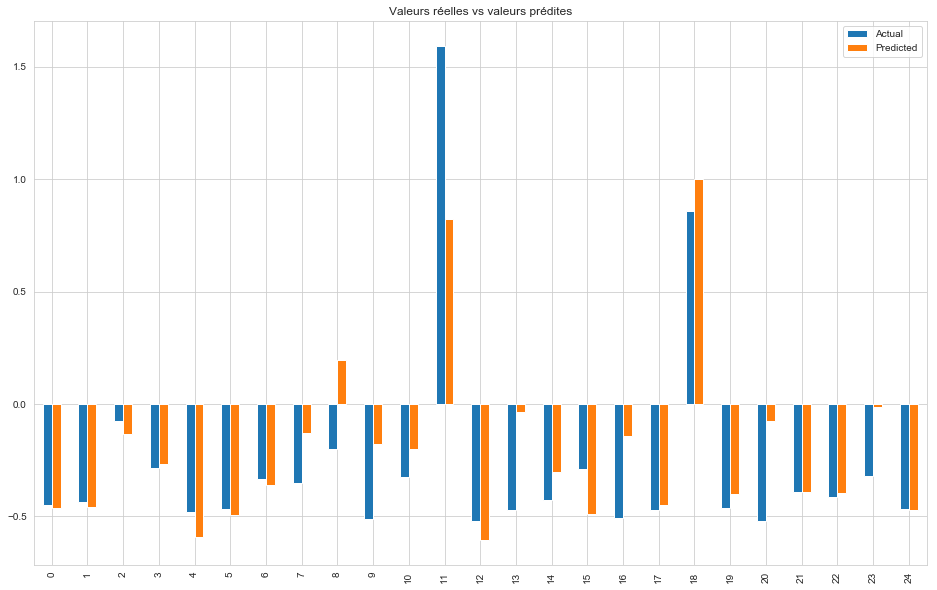

In [20]:
# Visualisations des 25 premieres valeurs reelles vs prédites
actual_vs_predicted.head(25).plot(kind='bar',figsize=(16,10))
plt.title('Valeurs réelles vs valeurs prédites')
plt.savefig('02 - Graphs/01 - Modelisation conso energie/linreg_actual_vs_predicted.png', dpi=200, bbox_inches='tight')
plt.show()

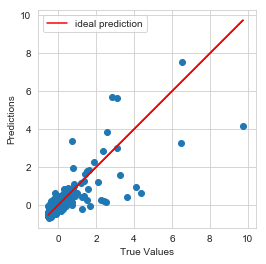

In [21]:
# Visualisation 
plt.scatter(y_test, linreg_y_pred)
plt.plot(y_test, y_test, color='r', label='ideal prediction')

plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('square')
plt.legend()

plt.savefig('02 - Graphs/01 - Modelisation conso energie/linreg_actual_vs_predicted_2.png', dpi=200, bbox_inches='tight')

plt.show()

***
**Root Mean Squared Error** (RMSE) is the square root of the mean of the squared errors:

$$\sqrt{\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2}$$

**RMSE** is even more popular than MSE, because RMSE is interpretable in the "y" units.

In [22]:
from sklearn import metrics

linreg_rmse = np.sqrt(metrics.mean_squared_error(y_test, linreg_y_pred))
print('Root Mean Squared Error:', linreg_rmse)

Root Mean Squared Error: 0.6183936243995103


In [23]:
linreg_accuracy = metrics.r2_score(y_test, linreg_y_pred)

print ('Linear Regression Accuracy:', linreg_accuracy)

Linear Regression Accuracy: 0.6175893253020373


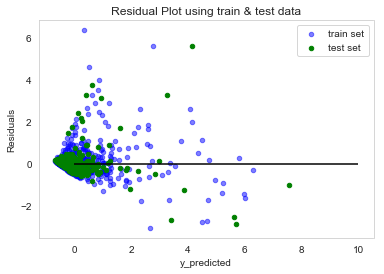

In [24]:
# Source: https://bigdata-madesimple.com/how-to-run-linear-regression-in-python-scikit-learn/
plt.scatter(linreg.predict(X_train), y_train-linreg.predict(X_train), color='blue', s=20, alpha=0.5, label='train set')
plt.scatter(linreg_y_pred, residual, color='green', s=20, label='test set')

plt.hlines(y=0, xmin=0, xmax =10)
plt.grid(b=None)
plt.title('Residual Plot using train & test data')
plt.ylabel('Residuals')
plt.xlabel('y_predicted')
plt.legend()

plt.savefig('02 - Graphs/01 - Modelisation conso energie/linreg_actual_vs_predicted_2.png', dpi=200, bbox_inches='tight')
plt.show()

Residual plots are a good way to visualize the errors in your data. If you have done a good job then your data should be randomly scattered around line zero. If you see structure in your data, that means your model is not capturing some thing. Maye be there is a interaction between 2 variables that you are not considering, or may be you are measuring time dependent data. If you get some structure in your data, you should go back to your model and check whether you are doing a good job with your parameters.

<a class="anchor" id="linreg_CV"></a>
***
#### 1.2.1.2. Regression linéaire (avec CV)

On utlise :
- cross_val_score si on a besoin que d'un retou d'un score
- cross_validate : on peut rentrer un dictionnaire pour avoir des scores differents
- cross_val_predict pour avoir les prédictions

In [25]:
# Pour visualiser les folds d'un CV

from sklearn.model_selection import KFold # import KFold

kf = KFold(n_splits=10) # Define the split
print (kf)
print(kf.get_n_splits(X)) # returns the number of splitting iterations in the cross-validator

KFold(n_splits=10, random_state=None, shuffle=False)
10


***

In [26]:
# Calculs des metrics r² et mse
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

linregCV_results = cross_validate(linreg, X_train, y_train, cv=10, scoring={'R2':'r2', 'MSE': make_scorer(mean_squared_error)}, return_train_score=True)
linregCV_results

{'fit_time': array([0.00399852, 0.00399876, 0.00299859, 0.00299788, 0.00599837,
        0.0029974 , 0.00199938, 0.00299883, 0.00299883, 0.00299907]),
 'score_time': array([0.        , 0.        , 0.0010004 , 0.        , 0.00099945,
        0.0010004 , 0.00099969, 0.        , 0.00099969, 0.        ]),
 'test_R2': array([0.75895145, 0.58264567, 0.79002319, 0.59679258, 0.47927882,
        0.75442947, 0.594537  , 0.70944283, 0.7393525 , 0.60410112]),
 'train_R2': array([0.67462871, 0.68742994, 0.66440498, 0.69023359, 0.71486626,
        0.6698256 , 0.68308271, 0.67750002, 0.67361946, 0.68911562]),
 'test_MSE': array([0.12361128, 0.35214765, 0.23159914, 0.50705726, 0.82006013,
        0.27331719, 0.34382436, 0.19927458, 0.22016049, 0.45418177]),
 'train_MSE': array([0.34200255, 0.31799077, 0.33174872, 0.3008149 , 0.26615305,
        0.32602257, 0.32192938, 0.33368055, 0.33198015, 0.30545723])}

In [27]:
# On récupère les 10 valeurs r²
linregCV_accuracies = linregCV_results['test_R2']

# Intervalles de confiance
linregCV_accuracy_interval = mean_confidence_interval(linregCV_accuracies, 0.96)

# Récupération des 3 valeurs
linregCV_accuracy = linregCV_accuracy_interval[0]
linregCV_accuracy_low = linregCV_accuracy_interval[1]
linregCV_accuracy_high = linregCV_accuracy_interval[2]

In [28]:
# On récupère les 10 valeurs MSE
linregCV_mses = linregCV_results['test_MSE']

# On calcule les rmse
linregCV_rmses = np.sqrt(linregCV_mses)

# Intervalles de confiance
linregCV_rmse_interval = mean_confidence_interval(linregCV_rmses, 0.96)

# Récupération des 3 valeurs
linregCV_rmse = linregCV_rmse_interval[0]
linregCV_rmse_low = linregCV_rmse_interval[1]
linregCV_rmse_high = linregCV_rmse_interval[2]

***

**Calcul du RMSE dans l'unité d'origine**

In [29]:
from sklearn.model_selection import cross_val_predict

# Make cross validated predictions
linreg_predictions_CV = cross_val_predict(linreg, X_train, y_train, cv=10)

In [30]:
# Source : https://www.youtube.com/watch?v=OYn-Mg2Sg20
# Bonne source : https://stackoverflow.com/questions/38058774/scikit-learn-how-to-scale-back-the-y-predicted-result
linreg_predictions_CV_unscale = sc_Y.inverse_transform(linreg_predictions_CV)

# Passage dans l'unité d'origine des y_train
y_train_unscale = sc_Y.inverse_transform(y_train)
y_train_unscale

array([ -412679.25106613,  6188576.10952762,  -249662.89493492, ...,
        2950215.38284906, 28382707.39344494,  7378213.33656085])

In [31]:
# RMSE
linregCV_rmse_unscale = np.sqrt(metrics.mean_squared_error(y_train_unscale, linreg_predictions_CV_unscale))
print('Root Mean Squared Error:', linregCV_rmse_unscale)

Root Mean Squared Error: 7953118.173715276


In [32]:
# Création d'un dataframe avec les différents résultats par modélisation
regressions_results = pd.DataFrame(columns=['Standardisation', 'Passage au log', 'Model', 'Accuracy', 'RMSE'])
regressions_results = regressions_results.append({'Standardisation': 'oui', 'Passage au log': 'non', 'Model': 'Regression linéaire', 'Accuracy': linregCV_accuracy, 'RMSE': linregCV_rmse_unscale}, ignore_index=True)
regressions_results

,Standardisation,Passage au log,Model,Accuracy,RMSE
0,oui,non,Regression linéaire,0.660955,7.953118e+06


***

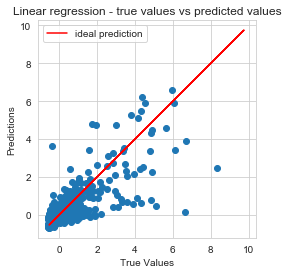

In [33]:
# Visualisation
plt.scatter(y_train, linreg_predictions_CV)
plt.plot(y_test, y_test, color='r', label='ideal prediction')

plt.title('Linear regression - true values vs predicted values')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('square')
plt.legend()

plt.savefig('02 - Graphs/01 - Modelisation conso energie/linreg_actual_vs_predicted_CV.png', dpi=200, bbox_inches='tight')

plt.show()

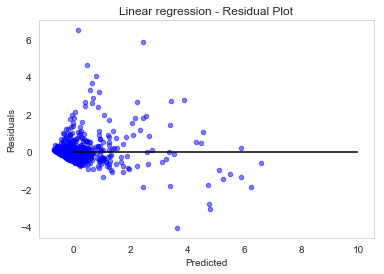

In [34]:
# Source: https://bigdata-madesimple.com/how-to-run-linear-regression-in-python-scikit-learn/
plt.scatter(linreg_predictions_CV, y_train - linreg_predictions_CV, color='blue', s=20, alpha=0.5)

plt.hlines(y=0, xmin=0, xmax =10)
plt.grid(b=None)
plt.title('Linear regression - Residual Plot')
plt.ylabel('Residuals')
plt.xlabel('Predicted')

plt.savefig('02 - Graphs/01 - Modelisation conso energie/linreg_actual_vs_predicted_CV_2.png', dpi=200, bbox_inches='tight')
plt.show()

***

In [35]:
# Création d'un dataframe avec les différents résultats par modélisation
model_results = pd.DataFrame(columns=['Standardisation', 'Passage au log', 'EnergyStarScore', 'Model', 'Accuracy', 'Accuracy_low', 'Accuracy_high', 'RMSE', 'RMSE_low', 'RMSE_high'])
model_results = model_results.append({'Standardisation': 'oui', 'Passage au log': 'non','EnergyStarScore':'non', 'Model': 'Regression linéaire', 'Accuracy': linregCV_accuracy, 'Accuracy_low': linregCV_accuracy_low, 'Accuracy_high': linregCV_accuracy_high ,'RMSE': linregCV_rmse, 'RMSE_low': linregCV_rmse_low , 'RMSE_high': linregCV_rmse_high}, ignore_index=True)
model_results

,Standardisation,Passage au log,EnergyStarScore,Model,Accuracy,Accuracy_low,Accuracy_high,RMSE,RMSE_low,RMSE_high
0,oui,non,non,Regression linéaire,0.660955,0.600737,0.721174,0.574261,0.48078,0.667742


<a class="anchor" id="regression_ridge"></a>
***
### 1.2.2. Régression Ridge 

So ridge regression puts constraint on the coefficients (). The penalty term (alpha) regularizes the coefficients such that if the coefficients take large values the optimization function is penalized. So, ridge regression shrinks the coefficients and it helps to reduce the model complexity and multi-collinearity

- higher the alpha value, more restriction on the coefficients
- low alpha > more generalization, coefficients are barely

<a class="anchor" id="ridge_alpha"></a>
***
#### 1.2.2.1. Recherche du meilleur alpha

In [36]:
from sklearn.linear_model import Ridge

# on cherche le meilleur alpha entre 200 valeurs entre 10^-5 et 10^5
n_alphas = 200
alphas = np.logspace(-5,5,n_alphas)

ridge = Ridge(random_state=116)
coefs = []
errors = []

for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(X_train, y_train)
    coefs.append(ridge.coef_)
    errors.append(np.sqrt(metrics.mean_squared_error(y_test, ridge.predict(X_test))))

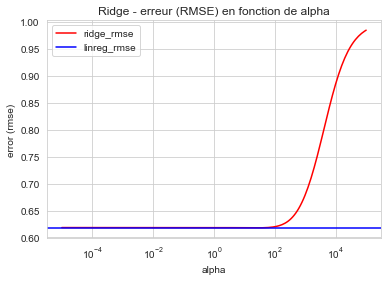

In [37]:
# Erreur (RMSE) en fonction de alpha

plt.plot(alphas, errors, color='red', label='ridge_rmse')
plt.axhline(y=linreg_rmse, color='blue', linestyle='-', label='linreg_rmse')

plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('error (rmse)')
plt.axis('tight')
plt.title('Ridge - erreur (RMSE) en fonction de alpha')
plt.legend()

plt.savefig('02 - Graphs/01 - Modelisation conso energie/ridge_rmse_alpha.png', dpi=200, bbox_inches='tight')
plt.show()

In [38]:
# Index de l'erreur la plus petite
np.argmin(errors)

127

In [39]:
# Calcul de Alpha [valeur dans la table Aphas à l'index 158]
ridge_alpha = alphas[np.argmin(errors)]
ridge_alpha

24.09403560239527

In [40]:
# RMSE au alpha optimal :
ridge_rmse = errors[np.argmin(errors)]
ridge_rmse

0.6178515487268426

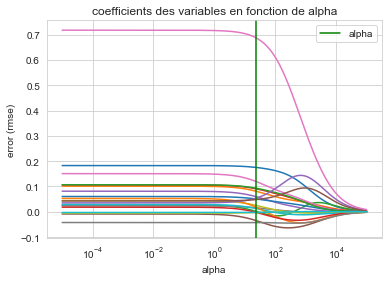

In [41]:
# Chemin de régularisation des coefficients
plt.plot(alphas, coefs)
plt.axvline(ridge_alpha, color='green', linestyle='-', label='alpha')

plt.title('coefficients des variables en fonction de alpha')
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('error (rmse)')
plt.axis('tight')
plt.legend()

plt.savefig('02 - Graphs/01 - Modelisation conso energie/ridge_coefs_alpha.png', dpi=200, bbox_inches='tight')
plt.show()

<a class="anchor" id="ridge_CV"></a>
***
#### 1.2.2.2. Regression Ridge (avec CV)

In [42]:
# Calculs des metrics r² et mse

ridgeCV_results = cross_validate(Ridge(alpha=ridge_alpha), X_train, y_train, cv=10, scoring={'R2':'r2', 'MSE': make_scorer(mean_squared_error)}, return_train_score=True)
ridgeCV_results

{'fit_time': array([0.00199938, 0.00099897, 0.        , 0.00099897, 0.        ,
        0.00099969, 0.00099945, 0.00099897, 0.00099945, 0.        ]),
 'score_time': array([0.        , 0.        , 0.00099969, 0.        , 0.00099945,
        0.        , 0.        , 0.        , 0.        , 0.00099921]),
 'test_R2': array([0.75503381, 0.58402231, 0.78125645, 0.59152306, 0.48168844,
        0.75110744, 0.61785974, 0.705695  , 0.74791121, 0.60248747]),
 'train_R2': array([0.67388595, 0.68662165, 0.66363132, 0.689505  , 0.71395759,
        0.66901175, 0.6820211 , 0.67681431, 0.67278433, 0.68837887]),
 'test_MSE': array([0.12562026, 0.35098609, 0.24126863, 0.51368401, 0.81626533,
        0.27701457, 0.32404716, 0.20184498, 0.21293123, 0.45603298]),
 'train_MSE': array([0.34278328, 0.31881307, 0.33251351, 0.30152244, 0.26700124,
        0.32682619, 0.32300778, 0.33439003, 0.33282961, 0.30618112])}

In [43]:
# On récupère les 10 valeurs r²
ridgeCV_accuracies = ridgeCV_results['test_R2']

# Intervalles de confiance
ridgeCV_accuracy_interval = mean_confidence_interval(ridgeCV_accuracies, 0.96)

# Récupération des 3 valeurs
ridgeCV_accuracy = ridgeCV_accuracy_interval[0]
ridgeCV_accuracy_low = ridgeCV_accuracy_interval[1]
ridgeCV_accuracy_high = ridgeCV_accuracy_interval[2]

In [44]:
# On récupère les 10 valeurs MSE
ridgeCV_mses = ridgeCV_results['test_MSE']

# On calcule les rmse
ridgeCV_rmses = np.sqrt(ridgeCV_mses)

# Intervalles de confiance
ridgeCV_rmse_interval = mean_confidence_interval(ridgeCV_rmses, 0.96)

# Récupération des 3 valeurs
ridgeCV_rmse = ridgeCV_rmse_interval[0]
ridgeCV_rmse_low = ridgeCV_rmse_interval[1]
ridgeCV_rmse_high = ridgeCV_rmse_interval[2]

***

**Calcul du RMSE dans l'unité d'origine**

In [45]:
from sklearn.model_selection import cross_val_predict

# Make cross validated predictions
ridge_predictions_CV = cross_val_predict(Ridge(alpha=ridge_alpha), X_train, y_train, cv=10)

In [46]:
# Source : https://www.youtube.com/watch?v=OYn-Mg2Sg20
# Bonne source : https://stackoverflow.com/questions/38058774/scikit-learn-how-to-scale-back-the-y-predicted-result
ridge_predictions_CV_unscale = sc_Y.inverse_transform(ridge_predictions_CV)

In [47]:
# RMSE
ridgeCV_rmse_unscale = np.sqrt(metrics.mean_squared_error(y_train_unscale, ridge_predictions_CV_unscale))
print('Root Mean Squared Error:', ridgeCV_rmse_unscale)

Root Mean Squared Error: 7946889.838066978


In [48]:
# Création d'un dataframe avec les différents résultats par modélisation
regressions_results = regressions_results.append({'Standardisation': 'oui', 'Passage au log': 'non', 'Model': 'Ridge', 'Accuracy': ridgeCV_accuracy, 'RMSE': ridgeCV_rmse_unscale}, ignore_index=True)
regressions_results

,Standardisation,Passage au log,Model,Accuracy,RMSE
0,oui,non,Regression linéaire,0.660955,7.953118e+06
1,oui,non,Ridge,0.661858,7.946890e+06


***

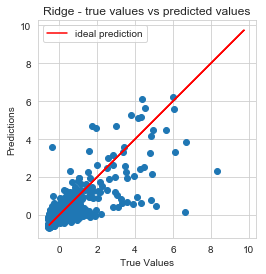

In [49]:
# Visualisation
plt.scatter(y_train, ridge_predictions_CV)
plt.plot(y_test, y_test, color='r', label='ideal prediction')

plt.title('Ridge - true values vs predicted values')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('square')
plt.legend()

plt.savefig('02 - Graphs/01 - Modelisation conso energie/ridge_actual_vs_predicted_CV.png', dpi=200, bbox_inches='tight')

plt.show()

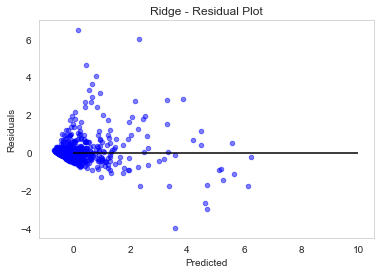

In [50]:
# Source: https://bigdata-madesimple.com/how-to-run-linear-regression-in-python-scikit-learn/
plt.scatter(ridge_predictions_CV, y_train - ridge_predictions_CV, color='blue', s=20, alpha=0.5)

plt.hlines(y=0, xmin=0, xmax =10)
plt.grid(b=None)
plt.title('Ridge - Residual Plot')
plt.ylabel('Residuals')
plt.xlabel('Predicted')

plt.savefig('02 - Graphs/01 - Modelisation conso energie/ridge_actual_vs_predicted_CV_2.png', dpi=200, bbox_inches='tight')
plt.show()

In [51]:
# Ajoutons les résultats au dataframe
model_results = model_results.append({'Standardisation': 'oui', 'Passage au log': 'non','EnergyStarScore':'non', 'Model': 'Ridge', 'Accuracy': ridgeCV_accuracy, 'Accuracy_low': ridgeCV_accuracy_low, 'Accuracy_high': ridgeCV_accuracy_high ,'RMSE': ridgeCV_rmse, 'RMSE_low': ridgeCV_rmse_low , 'RMSE_high': ridgeCV_rmse_high}, ignore_index=True)
model_results

,Standardisation,Passage au log,EnergyStarScore,Model,Accuracy,Accuracy_low,Accuracy_high,RMSE,RMSE_low,RMSE_high
0,oui,non,non,Regression linéaire,0.660955,0.600737,0.721174,0.574261,0.48078,0.667742
1,oui,non,non,Ridge,0.661858,0.603334,0.720383,0.573984,0.48099,0.666979


<a class="anchor" id="regression_lasso"></a>
***
### 1.2.3. Régression Lasso 

Le lasso peut donc être utilisé comme un algorithme de réduction de dimension supervisée.

<a class="anchor" id="lasso_alpha"></a>
***
#### 1.2.3.1. Recherche du meilleur alpha

In [52]:
from sklearn.linear_model import Lasso

# on cherche le meilleur alpha entre 200 valeurs entre 10^-5 et 10^5
n_alphas = 200
alphas = np.logspace(-5,10,n_alphas)

lasso = Lasso(random_state=116)
coefs = []
errors = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)
    errors.append(np.sqrt(metrics.mean_squared_error(y_test, lasso.predict(X_test))))

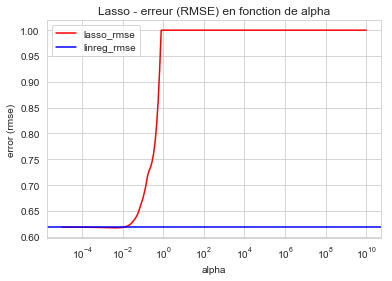

In [53]:
# Erreur (RMSE) en fonction de alpha

plt.plot(alphas, errors, color='red', label='lasso_rmse')
plt.axhline(y=linreg_rmse, color='blue', linestyle='-', label='linreg_rmse')

plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('error (rmse)')
plt.axis('tight')
plt.title('Lasso - erreur (RMSE) en fonction de alpha')
plt.legend()

plt.savefig('02 - Graphs/01 - Modelisation conso energie/lasso_rmse_alpha.png', dpi=200, bbox_inches='tight')
plt.show()

In [54]:
# Index de l'erreur la plus petite
np.argmin(errors)

34

In [55]:
# Calcul de Alpha [valeur dans la table Aphas à l'index 158]
lasso_alpha = alphas[np.argmin(errors)]
lasso_alpha

0.0036543830709572546

In [56]:
# RMSE au alpha optimal :
lasso_rmse = errors[np.argmin(errors)]
lasso_rmse

0.6170894533829158

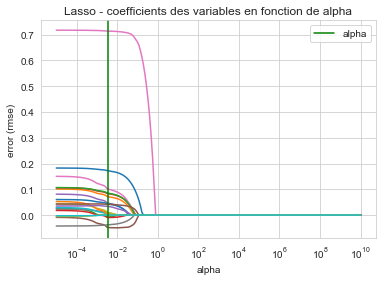

In [57]:
# Chemin de régularisation des coefficients
plt.plot(alphas, coefs)
plt.axvline(lasso_alpha, color='green', linestyle='-', label='alpha')

plt.title('Lasso - coefficients des variables en fonction de alpha')
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('error (rmse)')
plt.axis('tight')
plt.legend()

plt.savefig('02 - Graphs/01 - Modelisation conso energie/lasso_coefs_alpha.png', dpi=200, bbox_inches='tight')
plt.show()

<a class="anchor" id="lasso_CV"></a>
***
#### 1.2.3.2. Regression Lasso (avec CV)

In [58]:
# Calculs des metrics r² et mse

lassoCV_results = cross_validate(Lasso(alpha=lasso_alpha), X_train, y_train, cv=10, scoring={'R2':'r2', 'MSE': make_scorer(mean_squared_error)}, return_train_score=True)
lassoCV_results

{'fit_time': array([0.00099969, 0.        , 0.        , 0.00099993, 0.        ,
        0.        , 0.00099897, 0.00099897, 0.        , 0.        ]),
 'score_time': array([0.00100017, 0.00099969, 0.00099969, 0.00099897, 0.0010004 ,
        0.00100088, 0.        , 0.        , 0.00099969, 0.00099993]),
 'test_R2': array([0.75795632, 0.57940516, 0.78828696, 0.59584405, 0.47707417,
        0.75559848, 0.60557878, 0.70894936, 0.74650595, 0.60361414]),
 'train_R2': array([0.67380508, 0.68660684, 0.66353666, 0.68958001, 0.71393781,
        0.66894636, 0.68212613, 0.67692332, 0.6728061 , 0.68840757]),
 'test_MSE': array([0.12412159, 0.35488187, 0.23351415, 0.5082501 , 0.82353212,
        0.2720161 , 0.33446116, 0.19961302, 0.21411821, 0.45474044]),
 'train_MSE': array([0.34286829, 0.31882814, 0.33260709, 0.3014496 , 0.2670197 ,
        0.32689075, 0.32290109, 0.33427724, 0.33280746, 0.30615291])}

In [59]:
# On récupère les 10 valeurs r²
lassoCV_accuracies = lassoCV_results['test_R2']

# Intervalles de confiance
lassoCV_accuracy_interval = mean_confidence_interval(lassoCV_accuracies, 0.96)

# Récupération des 3 valeurs
lassoCV_accuracy = lassoCV_accuracy_interval[0]
lassoCV_accuracy_low = lassoCV_accuracy_interval[1]
lassoCV_accuracy_high = lassoCV_accuracy_interval[2]

In [60]:
# On récupère les 10 valeurs MSE
lassoCV_mses = lassoCV_results['test_MSE']

# On calcule les rmse
lassoCV_rmses = np.sqrt(lassoCV_mses)

# Intervalles de confiance
lassoCV_rmse_interval = mean_confidence_interval(lassoCV_rmses, 0.96)

# Récupération des 3 valeurs
lassoCV_rmse = lassoCV_rmse_interval[0]
lassoCV_rmse_low = lassoCV_rmse_interval[1]
lassoCV_rmse_high = lassoCV_rmse_interval[2]

***

**Calcul du RMSE dans l'unité d'origine**

In [61]:
from sklearn.model_selection import cross_val_predict

# Make cross validated predictions
lasso_predictions_CV = cross_val_predict(Lasso(alpha=lasso_alpha), X_train, y_train, cv=10)

In [62]:
# Source : https://www.youtube.com/watch?v=OYn-Mg2Sg20
# Bonne source : https://stackoverflow.com/questions/38058774/scikit-learn-how-to-scale-back-the-y-predicted-result
lasso_predictions_CV_unscale = sc_Y.inverse_transform(lasso_predictions_CV)

In [63]:
# RMSE
lassoCV_rmse_unscale = np.sqrt(metrics.mean_squared_error(y_train_unscale, lasso_predictions_CV_unscale))
print('Root Mean Squared Error:', lassoCV_rmse_unscale)

Root Mean Squared Error: 7946371.082082329


In [64]:
# Création d'un dataframe avec les différents résultats par modélisation
regressions_results = regressions_results.append({'Standardisation': 'oui', 'Passage au log': 'non', 'Model': 'Lasso', 'Accuracy': lassoCV_accuracy, 'RMSE': lassoCV_rmse_unscale}, ignore_index=True)
regressions_results

,Standardisation,Passage au log,Model,Accuracy,RMSE
0,oui,non,Regression linéaire,0.660955,7.953118e+06
1,oui,non,Ridge,0.661858,7.946890e+06
2,oui,non,Lasso,0.661881,7.946371e+06


***

***

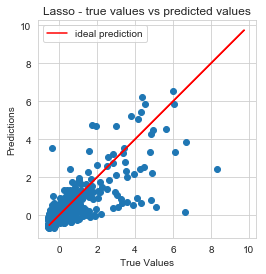

In [65]:
# Visualisation
plt.scatter(y_train, lasso_predictions_CV)
plt.plot(y_test, y_test, color='r', label='ideal prediction')

plt.title('Lasso - true values vs predicted values')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('square')
plt.legend()

plt.savefig('02 - Graphs/01 - Modelisation conso energie/lasso_actual_vs_predicted_CV.png', dpi=200, bbox_inches='tight')

plt.show()

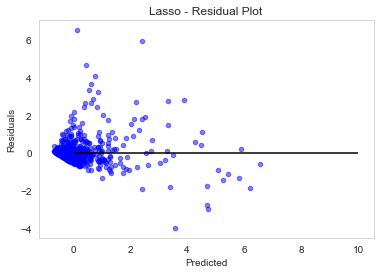

In [66]:
# Source: https://bigdata-madesimple.com/how-to-run-linear-regression-in-python-scikit-learn/
plt.scatter(lasso_predictions_CV, y_train - lasso_predictions_CV, color='blue', s=20, alpha=0.5)

plt.hlines(y=0, xmin=0, xmax =10)
plt.grid(b=None)
plt.title('Lasso - Residual Plot')
plt.ylabel('Residuals')
plt.xlabel('Predicted')

plt.savefig('02 - Graphs/01 - Modelisation conso energie/lasso_actual_vs_predicted_CV_2.png', dpi=200, bbox_inches='tight')
plt.show()

In [67]:
# Ajoutons les résultats au dataframe
model_results = model_results.append({'Standardisation': 'oui', 'Passage au log': 'non','EnergyStarScore':'non', 'Model': 'Lasso', 'Accuracy': lassoCV_accuracy, 'Accuracy_low': lassoCV_accuracy_low, 'Accuracy_high': lassoCV_accuracy_high ,'RMSE': lassoCV_rmse, 'RMSE_low': lassoCV_rmse_low , 'RMSE_high': lassoCV_rmse_high}, ignore_index=True)
model_results

,Standardisation,Passage au log,EnergyStarScore,Model,Accuracy,Accuracy_low,Accuracy_high,RMSE,RMSE_low,RMSE_high
0,oui,non,non,Regression linéaire,0.660955,0.600737,0.721174,0.574261,0.480780,0.667742
1,oui,non,non,Ridge,0.661858,0.603334,0.720383,0.573984,0.480990,0.666979
2,oui,non,non,Lasso,0.661881,0.601391,0.722372,0.573540,0.479588,0.667491


<a class="anchor" id="regressions_non_lineaires"></a>
***
## 1.3. Régressions non linéaires

<a class="anchor" id="svr"></a>
***
### 1.3.1. Support Vector Regression (SVR)

On a enlevé des outliers pour avoir des résultats pertinents

In [68]:
from sklearn.svm import SVR

# SVR linear
svr_lin = SVR(kernel='linear', degree=1)
svr_lin.fit(X_train,y_train)

# Prédictions
svr_lin_y_pred = svr_lin.predict(X_test)

In [69]:
# R²
svr_lin_accuracy = svr_lin.score(X_test,y_test)
print(svr_lin_accuracy)

0.619025348358382


In [70]:
# RMSE
svr_lin_rmse = np.sqrt(metrics.mean_squared_error(y_test, svr_lin_y_pred))
print('Root Mean Squared Error:', svr_lin_rmse)

Root Mean Squared Error: 0.617231440904964


**SVR linear avec CV**

In [71]:
# Calculs des metrics r² et mse
svr_linCV_results = cross_validate(svr_lin, X_train, y_train, cv=10, scoring={'R2':'r2', 'MSE': make_scorer(mean_squared_error)}, return_train_score=True)
svr_linCV_results

{'fit_time': array([0.16494513, 0.14695215, 0.15294981, 0.14295244, 0.13495564,
        0.14595342, 0.18494034, 0.16194749, 0.14995098, 0.1369555 ]),
 'score_time': array([0.00199914, 0.00199962, 0.00299954, 0.00300026, 0.00299907,
        0.00199938, 0.00199962, 0.00200009, 0.00300026, 0.00299931]),
 'test_R2': array([0.75619654, 0.52994063, 0.80021378, 0.58887909, 0.45455381,
        0.73777717, 0.63485709, 0.71246461, 0.79020128, 0.58978729]),
 'train_R2': array([0.65155136, 0.66450056, 0.63538338, 0.67089253, 0.69652235,
        0.64469664, 0.66182177, 0.64964049, 0.65003061, 0.66946637]),
 'test_MSE': array([0.12502401, 0.39661815, 0.22035918, 0.51700895, 0.85899843,
        0.29185101, 0.30963375, 0.19720213, 0.17721018, 0.47060284]),
 'train_MSE': array([0.36625949, 0.3413178 , 0.3604377 , 0.31959705, 0.28327585,
        0.35083554, 0.34352656, 0.36250592, 0.3559737 , 0.32476345])}

In [72]:
# On récupère les 10 valeurs r²
svr_linCV_accuracies = svr_linCV_results['test_R2']

# Intervalles de confiance
svr_linCV_accuracy_interval = mean_confidence_interval(svr_linCV_accuracies, 0.96)

# Récupération des 3 valeurs
svr_linCV_accuracy = svr_linCV_accuracy_interval[0]
svr_linCV_accuracy_low = svr_linCV_accuracy_interval[1]
svr_linCV_accuracy_high = svr_linCV_accuracy_interval[2]

In [73]:
# On récupère les 10 valeurs MSE
svr_linCV_mses = svr_linCV_results['test_MSE']

# On calcule les rmse
svr_linCV_rmses = np.sqrt(svr_linCV_mses)

# Intervalles de confiance
svr_linCV_rmse_interval = mean_confidence_interval(svr_linCV_rmses, 0.96)

# Récupération des 3 valeurs
svr_linCV_rmse = svr_linCV_rmse_interval[0]
svr_linCV_rmse_low = svr_linCV_rmse_interval[1]
svr_linCV_rmse_high = svr_linCV_rmse_interval[2]

In [74]:
# Predictions
svr_lin_predictions_CV = cross_val_predict(svr_lin, X_train, y_train, cv=10)
svr_lin_predictions_CV

array([-0.58950713, -0.3631637 , -0.48939296, ..., -0.32788179,
        0.89166104, -0.0276843 ])

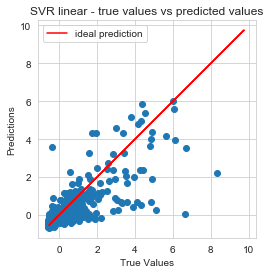

In [75]:
# Visualisation
plt.scatter(y_train, svr_lin_predictions_CV)
plt.plot(y_test, y_test, color='r', label='ideal prediction')

plt.title('SVR linear - true values vs predicted values')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('square')
plt.legend()

plt.savefig('02 - Graphs/01 - Modelisation conso energie/svr_lin_actual_vs_predicted_CV.png', dpi=200, bbox_inches='tight')

plt.show()

***

**SVR rbf avec CV**

In [76]:
# SVR rbf
svr_rbf = SVR(kernel='rbf', degree=1, gamma='auto')

In [77]:
# Calculs des metrics r² et mse
svr_rbfCV_results = cross_validate(svr_rbf, X_train, y_train, cv=10, scoring={'R2':'r2', 'MSE': make_scorer(mean_squared_error)}, return_train_score=True)
svr_rbfCV_results

{'fit_time': array([0.04398584, 0.04398561, 0.04398561, 0.04498529, 0.04098654,
        0.04296875, 0.04400206, 0.04498601, 0.04598498, 0.04498625]),
 'score_time': array([0.00499892, 0.00399804, 0.00499892, 0.00399828, 0.00399876,
        0.00499845, 0.00498176, 0.00499916, 0.00499868, 0.00399852]),
 'test_R2': array([0.59790297, 0.61319187, 0.65991174, 0.49479757, 0.41518406,
        0.63264079, 0.59889281, 0.63876018, 0.7197319 , 0.61847172]),
 'train_R2': array([0.69554502, 0.69134345, 0.68822164, 0.71315271, 0.72068015,
        0.69633981, 0.68890772, 0.6884786 , 0.68662201, 0.70633982]),
 'test_MSE': array([0.20619799, 0.32637393, 0.37510878, 0.63532204, 0.92100005,
        0.4088666 , 0.34013072, 0.24775129, 0.23673338, 0.43769558]),
 'train_MSE': array([0.32001711, 0.31400939, 0.30820503, 0.27855809, 0.26072618,
        0.29984177, 0.31601224, 0.32232136, 0.31875451, 0.28853371])}

In [78]:
# On récupère les 10 valeurs r²
svr_rbfCV_accuracies = svr_rbfCV_results['test_R2']

# Intervalles de confiance
svr_rbfCV_accuracy_interval = mean_confidence_interval(svr_rbfCV_accuracies, 0.96)

# Récupération des 3 valeurs
svr_rbfCV_accuracy = svr_rbfCV_accuracy_interval[0]
svr_rbfCV_accuracy_low = svr_rbfCV_accuracy_interval[1]
svr_rbfCV_accuracy_high = svr_rbfCV_accuracy_interval[2]

In [79]:
# On récupère les 10 valeurs MSE
svr_rbfCV_mses = svr_rbfCV_results['test_MSE']

# On calcule les rmse
svr_rbfCV_rmses = np.sqrt(svr_rbfCV_mses)

# Intervalles de confiance
svr_rbfCV_rmse_interval = mean_confidence_interval(svr_rbfCV_rmses, 0.96)

# Récupération des 3 valeurs
svr_rbfCV_rmse = svr_rbfCV_rmse_interval[0]
svr_rbfCV_rmse_low = svr_rbfCV_rmse_interval[1]
svr_rbfCV_rmse_high = svr_rbfCV_rmse_interval[2]

In [80]:
# Predictions
svr_rbf_predictions_CV = cross_val_predict(svr_rbf, X_train, y_train, cv=10)
svr_rbf_predictions_CV

array([-0.46563235, -0.29278604, -0.45827783, ..., -0.38554376,
        0.65312037,  0.1169791 ])

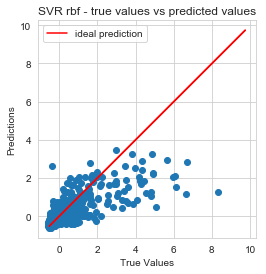

In [81]:
# Visualisation
plt.scatter(y_train, svr_rbf_predictions_CV)
plt.plot(y_test, y_test, color='r', label='ideal prediction')

plt.title('SVR rbf - true values vs predicted values')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('square')
plt.legend()

plt.savefig('02 - Graphs/01 - Modelisation conso energie/svr_rbf_actual_vs_predicted_CV.png', dpi=200, bbox_inches='tight')

plt.show()

***

**SVR poly avec CV**

In [82]:
# SVR poly
svr_poly = SVR(kernel='poly', degree=2, gamma='auto')

In [83]:
# Calculs des metrics r² et mse
svr_polyCV_results = cross_validate(svr_poly, X_train, y_train, cv=10, scoring={'R2':'r2', 'MSE': make_scorer(mean_squared_error)}, return_train_score=True)
svr_polyCV_results

{'fit_time': array([0.0469842 , 0.05298257, 0.04798508, 0.04498506, 0.04499459,
        0.05298138, 0.0629797 , 0.05798054, 0.05498075, 0.05098271]),
 'score_time': array([0.00300765, 0.002985  , 0.00199938, 0.00300336, 0.00299931,
        0.00299907, 0.00399971, 0.00399852, 0.00652242, 0.00299883]),
 'test_R2': array([0.51146235, 0.47097055, 0.72068884, 0.51064879, 0.41936239,
        0.65473168, 0.45801987, 0.59390846, 0.72505068, 0.43868249]),
 'train_R2': array([0.66041757, 0.66904556, 0.65537267, 0.67447   , 0.69805892,
        0.66475247, 0.65248489, 0.66455993, 0.65314523, 0.68362037]),
 'test_MSE': array([0.2505253 , 0.44637485, 0.30807318, 0.61538819, 0.91441979,
        0.38427969, 0.45958811, 0.27851222, 0.23224078, 0.64395277]),
 'train_MSE': array([0.35694009, 0.33669397, 0.34067751, 0.31612296, 0.28184157,
        0.33103191, 0.35301111, 0.34706925, 0.35280565, 0.31085654])}

In [84]:
# On récupère les 10 valeurs r²
svr_polyCV_accuracies = svr_polyCV_results['test_R2']

# Intervalles de confiance
svr_polyCV_accuracy_interval = mean_confidence_interval(svr_polyCV_accuracies, 0.96)

# Récupération des 3 valeurs
svr_polyCV_accuracy = svr_polyCV_accuracy_interval[0]
svr_polyCV_accuracy_low = svr_polyCV_accuracy_interval[1]
svr_polyCV_accuracy_high = svr_polyCV_accuracy_interval[2]

In [85]:
# On récupère les 10 valeurs MSE
svr_polyCV_mses = svr_polyCV_results['test_MSE']

# On calcule les rmse
svr_polyCV_rmses = np.sqrt(svr_polyCV_mses)

# Intervalles de confiance
svr_polyCV_rmse_interval = mean_confidence_interval(svr_polyCV_rmses, 0.96)

# Récupération des 3 valeurs
svr_polyCV_rmse = svr_polyCV_rmse_interval[0]
svr_polyCV_rmse_low = svr_polyCV_rmse_interval[1]
svr_polyCV_rmse_high = svr_polyCV_rmse_interval[2]

In [86]:
# Predictions
svr_poly_predictions_CV = cross_val_predict(svr_poly, X_train, y_train, cv=10)
svr_poly_predictions_CV

array([-0.42004439, -0.32491873, -0.44577173, ..., -0.42476567,
        0.4289356 , -0.03499842])

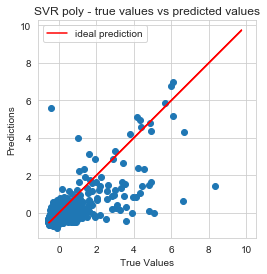

In [87]:
# Visualisation
plt.scatter(y_train, svr_poly_predictions_CV)
plt.plot(y_test, y_test, color='r', label='ideal prediction')

plt.title('SVR poly - true values vs predicted values')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('square')
plt.legend()

plt.savefig('02 - Graphs/01 - Modelisation conso energie/svr_poly_actual_vs_predicted_CV.png', dpi=200, bbox_inches='tight')

plt.show()

***

In [88]:
# Tout faire en une fois
for k in ['linear','poly','rbf','sigmoid']:
    clf = SVR(kernel=k, gamma='auto')
    clf.fit(X_train, y_train)
    #R²
    confidence = clf.score(X_test, y_test)
    # RMSE
    pred = clf.predict(X_test)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, pred))
    print(k,confidence, rmse)

linear 0.619025348358382 0.617231440904964
poly 0.5082541370036 0.7012459361710411
rbf 0.47612803680410887 0.7237899993754342
sigmoid -81.95309061797859 9.107858728481606


***

In [89]:
# Ajoutons les résultats au dataframe
model_results = model_results.append({'Standardisation': 'oui', 'Passage au log': 'non','EnergyStarScore':'non', 'Model': 'SVR linear', 'Accuracy': svr_linCV_accuracy, 'Accuracy_low': svr_linCV_accuracy_low, 'Accuracy_high': svr_linCV_accuracy_high ,'RMSE': svr_linCV_rmse, 'RMSE_low': svr_linCV_rmse_low , 'RMSE_high': svr_linCV_rmse_high}, ignore_index=True)
model_results = model_results.append({'Standardisation': 'oui', 'Passage au log': 'non','EnergyStarScore':'non', 'Model': 'SVR rbf', 'Accuracy': svr_rbfCV_accuracy, 'Accuracy_low': svr_rbfCV_accuracy_low, 'Accuracy_high': svr_rbfCV_accuracy_high ,'RMSE': svr_rbfCV_rmse, 'RMSE_low': svr_rbfCV_rmse_low , 'RMSE_high': svr_rbfCV_rmse_high}, ignore_index=True)
model_results = model_results.append({'Standardisation': 'oui', 'Passage au log': 'non','EnergyStarScore':'non', 'Model': 'SVR poly', 'Accuracy': svr_polyCV_accuracy, 'Accuracy_low': svr_polyCV_accuracy_low, 'Accuracy_high': svr_polyCV_accuracy_high ,'RMSE': svr_polyCV_rmse, 'RMSE_low': svr_polyCV_rmse_low , 'RMSE_high': svr_polyCV_rmse_high}, ignore_index=True)
model_results

,Standardisation,Passage au log,EnergyStarScore,Model,Accuracy,Accuracy_low,Accuracy_high,RMSE,RMSE_low,RMSE_high
0,oui,non,non,Regression linéaire,0.660955,0.600737,0.721174,0.574261,0.480780,0.667742
1,oui,non,non,Ridge,0.661858,0.603334,0.720383,0.573984,0.480990,0.666979
2,oui,non,non,Lasso,0.661881,0.601391,0.722372,0.573540,0.479588,0.667491
3,oui,non,non,SVR linear,0.659487,0.590355,0.728620,0.574637,0.474229,0.675045
4,oui,non,non,SVR rbf,0.598949,0.548509,0.649388,0.626312,0.535958,0.716666
5,oui,non,non,SVR poly,0.550353,0.482493,0.618212,0.657436,0.567374,0.747497


<a class="anchor" id="neural_network"></a>
***
### 1.3.2. Neural Network (MLPRegressor)

In [90]:
# Testons la meilleure fonction d'activation

from sklearn.neural_network import MLPRegressor

for k in ['identity', 'logistic', 'tanh', 'relu']:
    clf = MLPRegressor(random_state=0, activation=k, hidden_layer_sizes=16, max_iter=1000)
    clf.fit(X_train, y_train)
    #R²
    confidence = clf.score(X_test, y_test)
    # RMSE
    pred = clf.predict(X_test)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, pred))
    print(k,confidence, rmse)

identity 0.6221823836821097 0.6146687045212976
logistic 0.661142690193178 0.5821145160591874
tanh 0.7128869660475392 0.5358292955339983
relu 0.7027385406953074 0.5452168919839998


La fonction d'activation 'tanh' semble etre la meilleure.

**MLPRegressor tanh avec CV**

In [91]:
# On entraine le modèle avec la meilleure fonction d'activation
mlp = MLPRegressor(random_state=0, activation='tanh', hidden_layer_sizes=16, max_iter=1000)

In [92]:
# Calculs des metrics r² et mse
mlpCV_results = cross_validate(mlp, X_train, y_train, cv=10, scoring={'R2':'r2', 'MSE': make_scorer(mean_squared_error)}, return_train_score=True)
mlpCV_results

{'fit_time': array([2.09232259, 1.4135406 , 1.91337967, 0.93669581, 0.93712783,
        0.99123931, 1.10654569, 1.1177783 , 1.42054033, 1.49177837]),
 'score_time': array([0.00099945, 0.00099969, 0.        , 0.00100017, 0.00099993,
        0.00099921, 0.00099897, 0.00099945, 0.00199914, 0.00100088]),
 'test_R2': array([0.68618704, 0.67728377, 0.74277417, 0.4145326 , 0.53643608,
        0.7068573 , 0.63901519, 0.59559819, 0.61713731, 0.66167865]),
 'train_R2': array([0.84500176, 0.83876856, 0.84810733, 0.82359816, 0.85831886,
        0.82202572, 0.83030187, 0.83511591, 0.83520822, 0.84982552]),
 'test_MSE': array([0.16092534, 0.27229563, 0.28371361, 0.73626001, 0.73004576,
        0.32626447, 0.30610776, 0.27735334, 0.3233917 , 0.38812788]),
 'train_MSE': array([0.16292093, 0.16402758, 0.1501518 , 0.17130426, 0.13224976,
        0.17573632, 0.17238193, 0.17060036, 0.16761906, 0.14755286])}

In [93]:
# On récupère les 10 valeurs r²
mlpCV_accuracies = mlpCV_results['test_R2']

# Intervalles de confiance
mlpCV_accuracy_interval = mean_confidence_interval(mlpCV_accuracies, 0.96)

# Récupération des 3 valeurs
mlpCV_accuracy = mlpCV_accuracy_interval[0]
mlpCV_accuracy_low = mlpCV_accuracy_interval[1]
mlpCV_accuracy_high = mlpCV_accuracy_interval[2]

In [94]:
# On récupère les 10 valeurs MSE
mlpCV_mses = mlpCV_results['test_MSE']

# On calcule les rmse
mlpCV_rmses = np.sqrt(mlpCV_mses)

# Intervalles de confiance
mlpCV_rmse_interval = mean_confidence_interval(mlpCV_rmses, 0.96)

# Récupération des 3 valeurs
mlpCV_rmse = mlpCV_rmse_interval[0]
mlpCV_rmse_low = mlpCV_rmse_interval[1]
mlpCV_rmse_high = mlpCV_rmse_interval[2]

In [95]:
# Predictions
mlp_predictions_CV = cross_val_predict(mlp, X_train, y_train, cv=10)
mlp_predictions_CV

array([-0.48180209,  0.20735285, -0.47970668, ..., -0.31229934,
        1.12895541,  0.48417388])

In [96]:
# Ajoutons les résultats au dataframe
model_results = model_results.append({'Standardisation': 'oui', 'Passage au log': 'non','EnergyStarScore':'non', 'Model': 'MLPRegressor', 'Accuracy': mlpCV_accuracy, 'Accuracy_low': mlpCV_accuracy_low, 'Accuracy_high': mlpCV_accuracy_high ,'RMSE': mlpCV_rmse, 'RMSE_low': mlpCV_rmse_low , 'RMSE_high': mlpCV_rmse_high}, ignore_index=True)
model_results

,Standardisation,Passage au log,EnergyStarScore,Model,Accuracy,Accuracy_low,Accuracy_high,RMSE,RMSE_low,RMSE_high
0,oui,non,non,Regression linéaire,0.660955,0.600737,0.721174,0.574261,0.480780,0.667742
1,oui,non,non,Ridge,0.661858,0.603334,0.720383,0.573984,0.480990,0.666979
2,oui,non,non,Lasso,0.661881,0.601391,0.722372,0.573540,0.479588,0.667491
3,oui,non,non,SVR linear,0.659487,0.590355,0.728620,0.574637,0.474229,0.675045
4,oui,non,non,SVR rbf,0.598949,0.548509,0.649388,0.626312,0.535958,0.716666
5,oui,non,non,SVR poly,0.550353,0.482493,0.618212,0.657436,0.567374,0.747497
6,oui,non,non,MLPRegressor,0.627750,0.571768,0.683732,0.601089,0.515339,0.686839


***

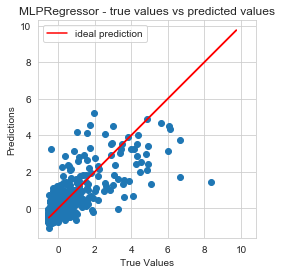

In [97]:
# Visualisation
plt.scatter(y_train, mlp_predictions_CV)
plt.plot(y_test, y_test, color='r', label='ideal prediction')

plt.title('MLPRegressor - true values vs predicted values')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('square')
plt.legend()

plt.savefig('02 - Graphs/01 - Modelisation conso energie/MLPRegressor_actual_vs_predicted_CV.png', dpi=200, bbox_inches='tight')

plt.show()

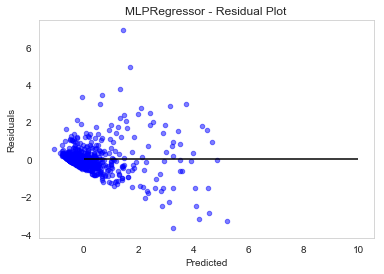

In [98]:
# Source: https://bigdata-madesimple.com/how-to-run-linear-regression-in-python-scikit-learn/
plt.scatter(mlp_predictions_CV, y_train - mlp_predictions_CV, color='blue', s=20, alpha=0.5)

plt.hlines(y=0, xmin=0, xmax =10)
plt.grid(b=None)
plt.title('MLPRegressor - Residual Plot')
plt.ylabel('Residuals')
plt.xlabel('Predicted')

plt.savefig('02 - Graphs/01 - Modelisation conso energie/MLPRegressor_actual_vs_predicted_CV_2.png', dpi=200, bbox_inches='tight')
plt.show()

<a class="anchor" id="methodes_ensemblistes"></a>
***
## 1.4. Méthodes ensemblistes - Random Forest

In [99]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Perform Grid-Search to find best parameters
gsc = GridSearchCV(estimator=RandomForestRegressor(), param_grid={'max_depth': range(3,7), 'n_estimators': (10, 50, 100, 1000)}, cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)

In [100]:
grid_result = gsc.fit(X_train, y_train)

In [101]:
best_params = grid_result.best_params_
best_params

{'max_depth': 6, 'n_estimators': 1000}

In [102]:
# Création du modèle avec les meilleurs paramètres
rfr = RandomForestRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"], random_state=False, verbose=False)

**Random Forest Regressor avec CV**

In [103]:
# Calculs des metrics r² et mse
rfrCV_results = cross_validate(rfr, X_train, y_train, cv=10, scoring={'R2':'r2', 'MSE': make_scorer(mean_squared_error)}, return_train_score=True)
rfrCV_results

{'fit_time': array([1.80583835, 1.79280329, 1.86528945, 1.87011099, 1.82010317,
        1.81384182, 1.82120395, 1.7846694 , 1.84533548, 1.871665  ]),
 'score_time': array([0.12494493, 0.06997728, 0.07197666, 0.08197761, 0.07097721,
        0.07098055, 0.06997824, 0.07097721, 0.13695478, 0.0779748 ]),
 'test_R2': array([0.71072507, 0.59324915, 0.72911179, 0.67714406, 0.53214403,
        0.75419423, 0.78927603, 0.69582098, 0.79856071, 0.72368414]),
 'train_R2': array([0.88894786, 0.90067535, 0.88849666, 0.8929269 , 0.8974658 ,
        0.8919427 , 0.88986067, 0.89811547, 0.89180664, 0.88893733]),
 'test_MSE': array([0.14834208, 0.34320083, 0.29878288, 0.40601052, 0.73680512,
        0.27357902, 0.17868963, 0.20861693, 0.17014924, 0.31699415]),
 'train_MSE': array([0.11672854, 0.10104718, 0.11022539, 0.10397895, 0.09570874,
        0.10669852, 0.1118812 , 0.10541671, 0.11004959, 0.10912383])}

In [104]:
# On récupère les 10 valeurs r²
rfrCV_accuracies = rfrCV_results['test_R2']

# Intervalles de confiance
rfrCV_accuracy_interval = mean_confidence_interval(rfrCV_accuracies, 0.96)

# Récupération des 3 valeurs
rfrCV_accuracy = rfrCV_accuracy_interval[0]
rfrCV_accuracy_low = rfrCV_accuracy_interval[1]
rfrCV_accuracy_high = rfrCV_accuracy_interval[2]

In [105]:
# On récupère les 10 valeurs MSE
rfrCV_mses = rfrCV_results['test_MSE']

# On calcule les rmse
rfrCV_rmses = np.sqrt(rfrCV_mses)

# Intervalles de confiance
rfrCV_rmse_interval = mean_confidence_interval(rfrCV_rmses, 0.96)

# Récupération des 3 valeurs
rfrCV_rmse = rfrCV_rmse_interval[0]
rfrCV_rmse_low = rfrCV_rmse_interval[1]
rfrCV_rmse_high = rfrCV_rmse_interval[2]

In [106]:
# Predictions
rfr_predictions_CV = cross_val_predict(rfr, X_train, y_train, cv=10)
rfr_predictions_CV

array([-0.46385054, -0.33666684, -0.46310259, ..., -0.21147477,
        0.81518086,  0.10173674])

In [107]:
# Ajoutons les résultats au dataframe
model_results = model_results.append({'Standardisation': 'oui', 'Passage au log': 'non','EnergyStarScore':'non', 'Model': 'Random Forest Regressor', 'Accuracy': rfrCV_accuracy, 'Accuracy_low': rfrCV_accuracy_low, 'Accuracy_high': rfrCV_accuracy_high ,'RMSE': rfrCV_rmse, 'RMSE_low': rfrCV_rmse_low , 'RMSE_high': rfrCV_rmse_high}, ignore_index=True)
model_results

,Standardisation,Passage au log,EnergyStarScore,Model,Accuracy,Accuracy_low,Accuracy_high,RMSE,RMSE_low,RMSE_high
0,oui,non,non,Regression linéaire,0.660955,0.600737,0.721174,0.574261,0.480780,0.667742
1,oui,non,non,Ridge,0.661858,0.603334,0.720383,0.573984,0.480990,0.666979
2,oui,non,non,Lasso,0.661881,0.601391,0.722372,0.573540,0.479588,0.667491
3,oui,non,non,SVR linear,0.659487,0.590355,0.728620,0.574637,0.474229,0.675045
4,oui,non,non,SVR rbf,0.598949,0.548509,0.649388,0.626312,0.535958,0.716666
5,oui,non,non,SVR poly,0.550353,0.482493,0.618212,0.657436,0.567374,0.747497
6,oui,non,non,MLPRegressor,0.627750,0.571768,0.683732,0.601089,0.515339,0.686839
7,oui,non,non,Random Forest Regressor,0.700391,0.651487,0.749295,0.539118,0.457200,0.621037


***

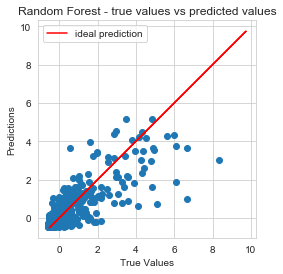

In [108]:
# Visualisation
plt.scatter(y_train, rfr_predictions_CV)
plt.plot(y_test, y_test, color='r', label='ideal prediction')

plt.title('Random Forest - true values vs predicted values')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('square')
plt.legend()

plt.savefig('02 - Graphs/01 - Modelisation conso energie/RandomForest_actual_vs_predicted_CV.png', dpi=200, bbox_inches='tight')

plt.show()

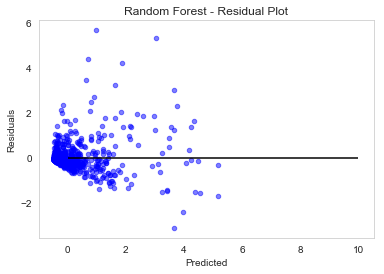

In [109]:
# Source: https://bigdata-madesimple.com/how-to-run-linear-regression-in-python-scikit-learn/
plt.scatter(rfr_predictions_CV, y_train - rfr_predictions_CV, color='blue', s=20, alpha=0.5)

plt.hlines(y=0, xmin=0, xmax =10)
plt.grid(b=None)
plt.title('Random Forest - Residual Plot')
plt.ylabel('Residuals')
plt.xlabel('Predicted')

plt.savefig('02 - Graphs/01 - Modelisation conso energie/Random Forest_actual_vs_predicted_CV_2.png', dpi=200, bbox_inches='tight')
plt.show()

<a class="anchor" id="resultats"></a>
***
# 2. Résultats

<a class="anchor" id="choix_modèle"></a>
***
## 2.1. Choix du modèle

In [110]:
model_results

,Standardisation,Passage au log,EnergyStarScore,Model,Accuracy,Accuracy_low,Accuracy_high,RMSE,RMSE_low,RMSE_high
0,oui,non,non,Regression linéaire,0.660955,0.600737,0.721174,0.574261,0.480780,0.667742
1,oui,non,non,Ridge,0.661858,0.603334,0.720383,0.573984,0.480990,0.666979
2,oui,non,non,Lasso,0.661881,0.601391,0.722372,0.573540,0.479588,0.667491
3,oui,non,non,SVR linear,0.659487,0.590355,0.728620,0.574637,0.474229,0.675045
4,oui,non,non,SVR rbf,0.598949,0.548509,0.649388,0.626312,0.535958,0.716666
5,oui,non,non,SVR poly,0.550353,0.482493,0.618212,0.657436,0.567374,0.747497
6,oui,non,non,MLPRegressor,0.627750,0.571768,0.683732,0.601089,0.515339,0.686839
7,oui,non,non,Random Forest Regressor,0.700391,0.651487,0.749295,0.539118,0.457200,0.621037


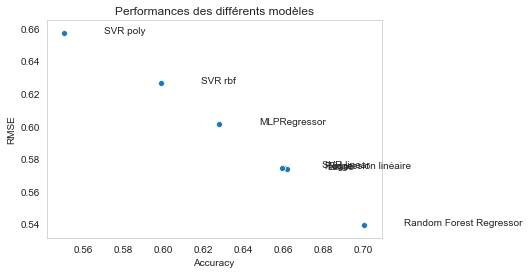

In [111]:
# identifions visuellement les outliers défini dans les données
sns.scatterplot(x="Accuracy", y='RMSE', data=model_results)

plt.grid(b=None)
plt.title('Performances des différents modèles')
plt.ylabel('RMSE')
plt.xlabel('Accuracy')


def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))

label_point(model_results["Accuracy"], model_results["RMSE"], model_results['Model'], plt.gca()) 


plt.savefig('02 - Graphs/01 - Modelisation conso energie/Choix modele.png', dpi=200, bbox_inches='tight')
plt.show()

Ces resultats sont changeants a chaque fois que l'on relance le code.

In [112]:
# Calculons l'amplitude des intervalles
model_results['Accuracy_interval'] = model_results['Accuracy_high'] - model_results['Accuracy_low']
model_results['RMSE_interval'] = model_results['RMSE_high'] - model_results['RMSE_low']

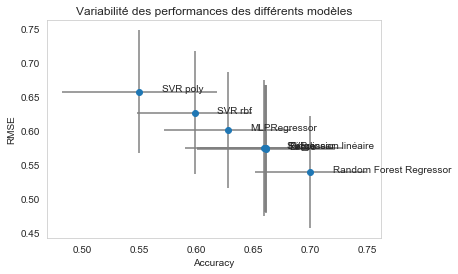

In [113]:
# Errorbar
plt.errorbar(model_results['Accuracy'], model_results['RMSE'], xerr=model_results['Accuracy_interval']/2, yerr=model_results['RMSE_interval']/2, fmt='o', ecolor='grey' )

plt.grid(b=None)
plt.title('Variabilité des performances des différents modèles')
plt.ylabel('RMSE')
plt.xlabel('Accuracy')

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))

label_point(model_results["Accuracy"], model_results["RMSE"], model_results['Model'], plt.gca()) 


plt.savefig('02 - Graphs/01 - Modelisation conso energie/Choix modele_2.png', dpi=200, bbox_inches='tight')
plt.show()

<a class="anchor" id="generalisation"></a>
***
## 2.2. Généralisation du modèle choisi

Le modèle Random Forest Regressor est le meilleur modèle.

In [114]:
best_params

{'max_depth': 6, 'n_estimators': 1000}

In [115]:
# Création du modèle avec les meilleurs paramètres
rfr_gen = RandomForestRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"], random_state=False, verbose=False)
rfr_gen.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=6,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
           oob_score=False, random_state=False, verbose=False,
           warm_start=False)

In [116]:
# Prédictions du modèle
rfr_gen_y_pred = rfr_gen.predict(X_test)

In [117]:
# Calculons les résidus 
residual = (y_test - rfr_gen_y_pred)

In [118]:
# Affichons les valeurs reelles VS les valeurs prédites
actual_vs_predicted = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': rfr_gen_y_pred.flatten()})
actual_vs_predicted.head()

,Actual,Predicted
0,-0.446998,-0.435184
1,-0.434414,-0.400337
2,-0.073730,-0.173436
3,-0.282654,-0.191984
4,-0.478554,-0.408074


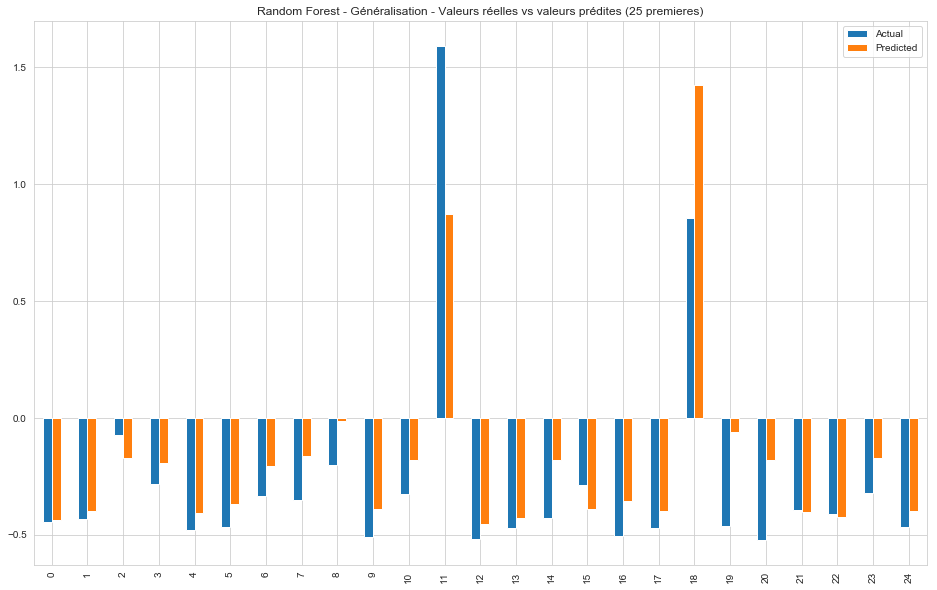

In [119]:
# Visualisations des 25 premieres valeurs reelles vs prédites
actual_vs_predicted.head(25).plot(kind='bar',figsize=(16,10))
plt.title('Random Forest - Généralisation - Valeurs réelles vs valeurs prédites (25 premieres)')
plt.savefig('02 - Graphs/01 - Modelisation conso energie/rfr_gen_actual_vs_predicted.png', dpi=200, bbox_inches='tight')
plt.show()

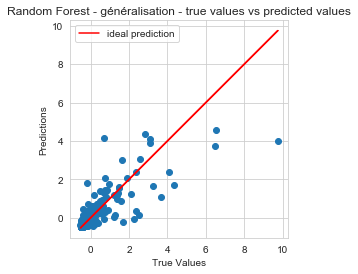

In [120]:
# Visualisation 
plt.scatter(y_test, rfr_gen_y_pred)
plt.plot(y_test, y_test, color='r', label='ideal prediction')

plt.title('Random Forest - généralisation - true values vs predicted values')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('square')
plt.legend()

plt.savefig('02 - Graphs/01 - Modelisation conso energie/rfr_gen_actual_vs_predicted_2.png', dpi=200, bbox_inches='tight')

plt.show()

In [121]:
# RMSE
rfr_gen_rmse = np.sqrt(metrics.mean_squared_error(y_test, rfr_gen_y_pred))
print('Root Mean Squared Error:', rfr_gen_rmse)

Root Mean Squared Error: 0.5794059334602722


In [122]:
# R²
rfr_gen_accuracy = rfr_gen.score(X_test, y_test)
rfr_gen_accuracy

0.6642887642710306

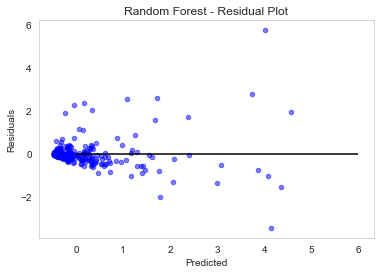

In [123]:
# Source: https://bigdata-madesimple.com/how-to-run-linear-regression-in-python-scikit-learn/
plt.scatter(rfr_gen_y_pred, y_test - rfr_gen_y_pred, color='blue', s=20, alpha=0.5)

plt.hlines(y=0, xmin=0, xmax =6)
plt.grid(b=None)
plt.title('Random Forest - Residual Plot')
plt.ylabel('Residuals')
plt.xlabel('Predicted')

plt.savefig('02 - Graphs/01 - Modelisation conso energie/rfr_gen_actual_vs_predicted_CV_3.png', dpi=200, bbox_inches='tight')
plt.show()

Residual plots are a good way to visualize the errors in your data. If you have done a good job then your data should be randomly scattered around line zero. If you see structure in your data, that means your model is not capturing some thing. Maye be there is a interaction between 2 variables that you are not considering, or may be you are measuring time dependent data. If you get some structure in your data, you should go back to your model and check whether you are doing a good job with your parameters.

In [124]:
# Ajoutons les résultats au dataframe
model_results = model_results.append({'Standardisation': 'oui', 'Passage au log': 'non','EnergyStarScore':'non', 'Model': 'Random Forest Regressor Genéralisation', 'Accuracy': rfr_gen_accuracy, 'RMSE': rfr_gen_rmse}, ignore_index=True)
model_results

,Standardisation,Passage au log,EnergyStarScore,Model,Accuracy,Accuracy_low,Accuracy_high,RMSE,RMSE_low,RMSE_high,Accuracy_interval,RMSE_interval
0,oui,non,non,Regression linéaire,0.660955,0.600737,0.721174,0.574261,0.480780,0.667742,0.120438,0.186962
1,oui,non,non,Ridge,0.661858,0.603334,0.720383,0.573984,0.480990,0.666979,0.117048,0.185989
2,oui,non,non,Lasso,0.661881,0.601391,0.722372,0.573540,0.479588,0.667491,0.120982,0.187903
3,oui,non,non,SVR linear,0.659487,0.590355,0.728620,0.574637,0.474229,0.675045,0.138265,0.200816
4,oui,non,non,SVR rbf,0.598949,0.548509,0.649388,0.626312,0.535958,0.716666,0.100880,0.180709
5,oui,non,non,SVR poly,0.550353,0.482493,0.618212,0.657436,0.567374,0.747497,0.135719,0.180123
6,oui,non,non,MLPRegressor,0.627750,0.571768,0.683732,0.601089,0.515339,0.686839,0.111965,0.171500
7,oui,non,non,Random Forest Regressor,0.700391,0.651487,0.749295,0.539118,0.457200,0.621037,0.097807,0.163837
8,oui,non,non,Random Forest Regressor Genéralisation,0.664289,NaN,NaN,0.579406,NaN,NaN,NaN,NaN


Le modèle généralise bien (erreurs et r² de la mm grandeur entre train et test)

***

In [125]:
# Sauvegardes des résultats :
model_results.to_excel("03 - Results/mod_results_energie.xlsx")
regressions_results.to_excel("03 - Results/regressions_results_energie.xlsx")

***

In [126]:
# Voir toutes les variables
%whos 

Variable                        Type                     Data/Info
------------------------------------------------------------------
GridSearchCV                    ABCMeta                  <class 'sklearn.model_sel<...>on._search.GridSearchCV'>
KFold                           ABCMeta                  <class 'sklearn.model_selection._split.KFold'>
Lasso                           ABCMeta                  <class 'sklearn.linear_mo<...>oordinate_descent.Lasso'>
LinearRegression                ABCMeta                  <class 'sklearn.linear_mo<...>l.base.LinearRegression'>
MLPRegressor                    ABCMeta                  <class 'sklearn.neural_ne<...>perceptron.MLPRegressor'>
RandomForestRegressor           ABCMeta                  <class 'sklearn.ensemble.<...>t.RandomForestRegressor'>
Ridge                           ABCMeta                  <class 'sklearn.linear_model.ridge.Ridge'>
SVR                             ABCMeta                  <class 'sklearn.svm.classes.SVR'>
Standa

***
[Top de la page](#top)